In [ ]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 박스 플롯 hue 구현 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
tips = sns.load_dataset('tips')

# 데이터 준비
days = tips['day'].unique()
smokers = tips['smoker'].unique()

plt.figure(figsize=(8, 5))

# 각 day와 smoker 그룹별로 박스플롯 그리기
positions = []
data_to_plot = []
pos = 1

for day in sorted(days):  # day 순서대로
    for smoker in sorted(smokers):  # smoker = No, Yes
        group = tips[(tips['day'] == day) & (tips['smoker'] == smoker)]['total_bill']
        data_to_plot.append(group)
        positions.append(pos)
        pos += 1
    pos += 1  # day 사이 간격

# 박스플롯 그리기
bp = plt.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)

# 색상 채우기 (smoker 구분)
colors = ['lightblue', 'lightcoral'] * len(days)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# x축 레이블: day 가운데 배치
xticks = []
xlabels = []
for i, day in enumerate(sorted(days)):
    xticks.append((i* (len(smokers)+1)) + 1.5)  # day 그룹의 중앙
    xlabels.append(day)

plt.xticks(xticks, xlabels)
plt.xlabel("day")
plt.ylabel("total_bill")
plt.title('Total Bill Distribution by Day and Smoker')

# 범례 추가
from matplotlib.patches import Patch
legend_handles = [Patch(color='lightblue', label='No'),
                  Patch(color='lightcoral', label='Yes')]
plt.legend(handles=legend_handles, title="smoker")

plt.show()

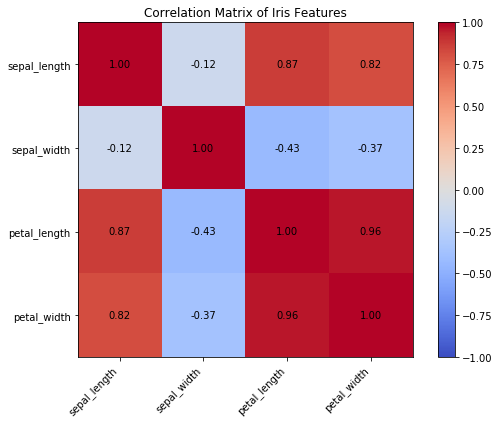

In [49]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 heatmap 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
iris = sns.load_dataset('iris')

# 수치형 변수 간 상관계수 계산
corr = iris.corr()

# 히트맵 그리기
fig, ax = plt.subplots(figsize=(8, 6))

# imshow로 색상 맵 시각화
cax = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)

# 컬럼 이름으로 x, y축 라벨 설정
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# 각 셀에 상관계수 값 표시
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center', color='black')

# 컬러바 추가
fig.colorbar(cax)

plt.title('Correlation Matrix of Iris Features')
plt.tight_layout()
plt.show()


In [12]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. 데이터 준비 (붓꽃 데이터 - 다중 분류)
iris = load_iris()
X = iris.data
y = iris.target

# 2. 데이터 분할 및 스케일링
# 층화 샘플링(stratify=y)을 통해 훈련/테스트 세트의 클래스 비율을 동일하게 유지
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. 모델 학습
# LogisticRegression 주요 하이퍼파라미터
# penalty: 규제 종류 ('l1', 'l2', 'elasticnet', 'none'). (기본값='l2')
# C: 규제 강도의 역수. 작을수록 강한 규제. (기본값=1.0)
# solver: 최적화 알고리즘. ('liblinear'은 이진 분류만 지원, 'lbfgs', 'saga' 등은 다중 분류 지원)
# multi_class: 다중 분류 방식 ('ovr'는 일대다, 'multinomial'은 소프트맥스). (기본값='auto')
# class_weight: 클래스 불균형 처리 ('balanced' 또는 dict).
log_reg = LogisticRegression(
    C=1.0, 
    solver='lbfgs', 
    multi_class='multinomial', # 소프트맥스 회귀 사용
    random_state=42
)
log_reg.fit(X_train_scaled, y_train)

# 4. 예측 및 평가
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)

print("--- 로지스틱 회귀 모델 평가 ---")
print(f"정확도: {accuracy_score(y_test, y_pred):.3f}")
print("\n혼동 행렬:\n", confusion_matrix(y_test, y_pred))
print("\n분류 리포트:\n", classification_report(y_test, y_pred))

# 예측 확률 확인 (첫 5개 샘플)
print("\n예측 확률 (첫 5개 샘플):\n", pd.DataFrame(y_pred_proba[:5], columns=iris.target_names))

# 5. 학습된 계수 확인
# 다중 분류에서는 (클래스 개수, 특성 개수) 형태의 계수가 생성됨
print("\n절편 (intercept):", log_reg.intercept_)
print("회귀 계수 (coefficients) shape:", log_reg.coef_.shape)

--- 로지스틱 회귀 모델 평가 ---
정확도: 0.911

혼동 행렬:
 [[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]

분류 리포트:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.82      0.93      0.87        15
           2       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


예측 확률 (첫 5개 샘플):
      setosa  versicolor  virginica
0  0.000033    0.101593   0.898374
1  0.014130    0.789644   0.196226
2  0.003589    0.620538   0.375873
3  0.021821    0.629399   0.348780
4  0.005156    0.384716   0.610128

절편 (intercept): [-0.3296466   1.78618973 -1.45654313]
회귀 계수 (coefficients) shape: (3, 4)


In [16]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 1. 데이터 준비 및 전처리
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# KNN은 스케일링이 매우 중요
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. KNN 모델 학습
# KNeighborsClassifier 주요 하이퍼파라미터
# n_neighbors: 이웃의 수 (K). (기본값=5)
# weights: 예측에 사용될 가중치. 'uniform'(동일 가중치), 'distance'(거리에 반비례하는 가중치).
# metric: 거리 측정 방법. 'minkowski'(기본값, p=2이면 유클리드 거리), 'manhattan' 등.
# p: minkowski 거리의 파라미터. (기본값=2)
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_scaled, y_train)
knn_pred = knn_clf.predict(X_test_scaled)
print(f"KNN (K=5) 정확도: {accuracy_score(y_test, knn_pred):.3f}")

# 3. GridSearchCV를 이용한 최적 K 찾기
param_grid = {'n_neighbors': np.arange(1, 30)}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled, y_train)

print(f"\nGridSearchCV 최적 K: {grid_knn.best_params_['n_neighbors']}")
print(f"최적 K 적용 시 정확도: {grid_knn.best_score_:.3f} (교차검증 평균)")

# 최적 모델로 예측
best_knn = grid_knn.best_estimator_
best_pred = best_knn.predict(X_test_scaled)
print(f"Best KNN 정확도: {accuracy_score(y_test, best_pred):.3f}")

KNN (K=5) 정확도: 0.911

GridSearchCV 최적 K: 14
최적 K 적용 시 정확도: 0.971 (교차검증 평균)
Best KNN 정확도: 0.956


In [18]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# 1. 데이터 준비 및 전처리
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# SVC는 스케일링이 매우 중요
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. SVC 모델 학습 (RBF 커널)
# 주요 하이퍼파라미터
# kernel: 커널 종류 ('linear', 'poly', 'rbf', 'sigmoid')
# C: 규제 파라미터
# gamma: 커널 계수
svc_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svc_rbf.fit(X_train_scaled, y_train)
svc_pred = svc_rbf.predict(X_test_scaled)
print(f"SVC (RBF Kernel) 정확도: {accuracy_score(y_test, svc_pred):.3f}")

SVC (RBF Kernel) 정확도: 0.977


In [19]:
# 3. GridSearchCV를 이용한 최적 하이퍼파라미터 탐색
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

grid_svc = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train_scaled, y_train)

print("\nGridSearchCV 최적 파라미터 (SVC):", grid_svc.best_params_)
print(f"최적 파라미터 적용 시 정확도: {grid_svc.best_score_:.3f} (교차검증 평균)")

# 최적 모델로 예측 및 평가
best_svc = grid_svc.best_estimator_
best_pred = best_svc.predict(X_test_scaled)
print("\nBest SVC 분류 리포트:\n", classification_report(y_test, best_pred))


GridSearchCV 최적 파라미터 (SVC): {'C': 10, 'gamma': 0.01}
최적 파라미터 적용 시 정확도: 0.975 (교차검증 평균)

Best SVC 분류 리포트:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98        64
           1       0.99      0.98      0.99       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



Decision Tree 정확도: 0.924
Random Forest 정확도: 0.942

Feature Importances:
 worst concave points    0.163779
worst area              0.152536
worst perimeter         0.087027
mean radius             0.078079
worst radius            0.075766
mean perimeter          0.075618
mean concave points     0.063133
mean concavity          0.055289
mean area               0.042579
worst concavity         0.031887
dtype: float64


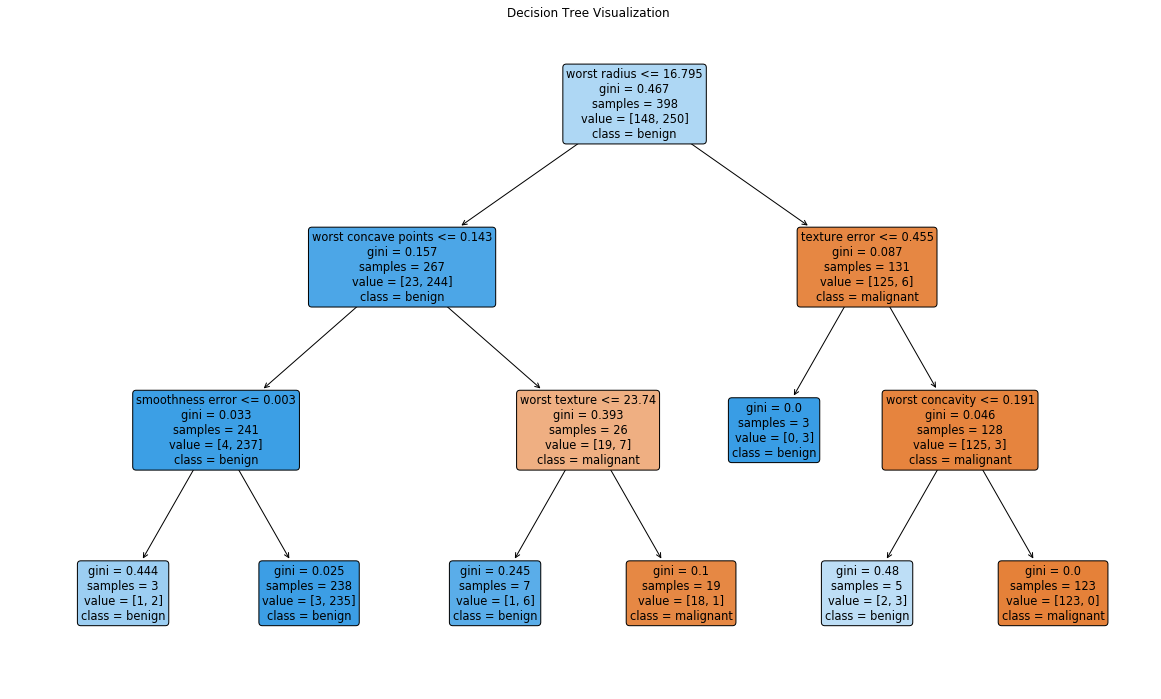

In [22]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 1. 데이터 준비
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2. 결정 트리 분류
# 주요 하이퍼파라미터
# criterion: 분할 품질 측정 기준 ('gini' 또는 'entropy')
# max_depth: 트리의 최대 깊이.
dt_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print(f"Decision Tree 정확도: {accuracy_score(y_test, dt_pred):.3f}")

# 3. 랜덤 포레스트 분류
# 주요 하이퍼파라미터
# n_estimators: 생성할 트리의 개수.
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print(f"Random Forest 정확도: {accuracy_score(y_test, rf_pred):.3f}")

# 4. 특성 중요도 (Feature Importance) 확인
importances = pd.Series(rf_clf.feature_importances_, index=cancer.feature_names)
print("\nFeature Importances:\n", importances.sort_values(ascending=False).head(10))

# 5. 모델 시각화 (결정 트리)
plt.figure(figsize=(20, 12))
plot_tree(dt_clf, feature_names=cancer.feature_names, class_names=cancer.target_names, filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

In [23]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# 1. 데이터 준비
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. 그래디언트 부스팅 (Scikit-learn)
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
print(f"Gradient Boosting 정확도: {accuracy_score(y_test, gb_pred):.3f}")

# 3. XGBoost
# !pip install xgboost
import xgboost as xgb
# 이진 분류의 경우, objective='binary:logistic'
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, 
                            objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
print(f"XGBoost 정확도: {accuracy_score(y_test, xgb_pred):.3f}")

# 4. LightGBM
# !pip install lightgbm
import lightgbm as lgb
lgbm_clf = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)
print(f"LightGBM 정확도: {accuracy_score(y_test, lgbm_pred):.3f}")

# 5. 조기 종료(Early Stopping) 기능 활용 (XGBoost 예시)
# 검증 세트 준비
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

xgb_clf_early = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, random_state=42,
                                  objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
# early_stopping_rounds: 검증 성능이 향상되지 않아도 기다릴 반복 횟수
# eval_set: 성능 평가에 사용할 검증 세트
xgb_clf_early.fit(X_train_sub, y_train_sub, 
                  eval_set=[(X_val, y_val)], 
                  early_stopping_rounds=100, 
                  verbose=False) # verbose=True로 하면 학습 과정 출력

early_pred = xgb_clf_early.predict(X_test)
early_pred_proba = xgb_clf_early.predict_proba(X_test)[:, 1]
print(f"\nXGBoost (Early Stopping) 정확도: {accuracy_score(y_test, early_pred):.3f}")
print(f"XGBoost (Early Stopping) AUC: {roc_auc_score(y_test, early_pred_proba):.3f}")

Gradient Boosting 정확도: 0.956
XGBoost 정확도: 0.956
LightGBM 정확도: 0.956

XGBoost (Early Stopping) 정확도: 0.939
XGBoost (Early Stopping) AUC: 0.990


In [24]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. 데이터 준비
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2. 가우시안 나이브 베이즈 모델 학습
# GaussianNB 주요 하이퍼파라미터
# priors: 각 클래스의 사전 확률. None이면 데이터에 따라 자동 계산.
# var_smoothing: 분산 계산 시 안정성을 위해 더해주는 작은 값. (기본값=1e-9)
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)

# 3. 예측 및 평가
y_pred = gnb_clf.predict(X_test)
y_pred_proba = gnb_clf.predict_proba(X_test)

print("--- 가우시안 나이브 베이즈 모델 평가 ---")
print(f"정확도: {accuracy_score(y_test, y_pred):.3f}")
print("\n혼동 행렬:\n", confusion_matrix(y_test, y_pred))
print("\n분류 리포트:\n", classification_report(y_test, y_pred))

# 4. 학습된 파라미터 확인
print("\n클래스별 사전 확률 (priors):", gnb_clf.class_prior_)
print("클래스별 특성의 평균 (theta):", gnb_clf.theta_)
print("클래스별 특성의 분산 (sigma):", gnb_clf.sigma_)

--- 가우시안 나이브 베이즈 모델 평가 ---
정확도: 0.911

혼동 행렬:
 [[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]

분류 리포트:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.82      0.93      0.87        15
           2       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


클래스별 사전 확률 (priors): [0.33333333 0.33333333 0.33333333]
클래스별 특성의 평균 (theta): [[4.98857143 3.42571429 1.48571429 0.24      ]
 [5.94857143 2.73142857 4.23714286 1.30857143]
 [6.68285714 3.00857143 5.63142857 2.06857143]]
클래스별 특성의 분산 (sigma): [[0.10329796 0.17391021 0.02293878 0.00925715]
 [0.24078368 0.08558368 0.21147755 0.03564082]
 [0.42484898 0.11735511 0.32272653 0.06386939]]
